In [65]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib
import folium
import warnings
# from statsmodels.tools.sm_exceptions import ConvergenceWarning
# warnings.simplefilter('ignore', ConvergenceWarning)
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline

In [66]:
df_raw = pd.read_csv('zillow_data.csv')
df_raw.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [67]:
# Import zipcode database to pair with data
df_Zipcode = pd.read_csv('zip_code_database.csv')

In [68]:
# Rename RegionName to Zipcode to merge data from zip code import
df_raw.rename(columns={'RegionName': 'Zipcode'}, inplace = True)

In [69]:
# Drop other columns and keep Zipcode (for merge), Lat/Long, and estimated Population
df_Zipcode.rename(columns={'zip':'Zipcode'}, inplace = True)
df_Zipcode = df_Zipcode[['Zipcode', 'latitude', 'longitude', 'irs_estimated_population' ]]
df_Zipcode.head()

,Zipcode,latitude,longitude,irs_estimated_population
0,501,40.81,-73.04,562
1,544,40.81,-73.04,0
2,601,18.16,-66.72,0
3,602,18.38,-67.18,0
4,603,18.43,-67.15,0


In [70]:
df = df_raw.merge(df_Zipcode, on = 'Zipcode')
df.head()


,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1009600,1013300,1018700,1024400,1030700,1033800,1030600,41.94,-87.65,54760
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,314100,315000,316600,318100,319600,321100,321800,33.17,-96.70,56810
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,320400,320800,321200,321200,323000,326900,329900,29.74,-95.83,125330
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1291500,1296600,1299000,1302700,1306400,1308500,1307000,41.92,-87.65,52800
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,120300,120300,120300,120300,120500,121000,121500,31.78,-106.30,99590


In [71]:
#Dividing zipcodes into region 
df_East = df[df_raw.Zipcode < 50000]
df_Central = df[(df_raw.Zipcode >= 50000) & (df_raw.Zipcode < 80000) ]
df_West = df[(df.Zipcode >= 80000)]

#Cenral** 
df_Central.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1009600,1013300,1018700,1024400,1030700,1033800,1030600,41.94,-87.65,54760
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,314100,315000,316600,318100,319600,321100,321800,33.17,-96.70,56810
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,320400,320800,321200,321200,323000,326900,329900,29.74,-95.83,125330
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1291500,1296600,1299000,1302700,1306400,1308500,1307000,41.92,-87.65,52800
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,120300,120300,120300,120300,120500,121000,121500,31.78,-106.30,99590


In [72]:
# Texas Data frame
TX_df_uf = df_Central[(df_Central['State'] == 'TX')]
TX_df_uf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 989 entries, 1 to 14695
Columns: 275 entries, RegionID to irs_estimated_population
dtypes: float64(221), int64(50), object(4)
memory usage: 2.1+ MB


In [73]:
print(TX_df_uf.shape)
TX_df_uf.head()

(989, 275)


,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,314100,315000,316600,318100,319600,321100,321800,33.17,-96.70,56810
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,320400,320800,321200,321200,323000,326900,329900,29.74,-95.83,125330
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,120300,120300,120300,120300,120500,121000,121500,31.78,-106.30,99590
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,161900,162800,162800,162800,162900,163500,164300,29.83,-95.66,99740
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,169600,170900,172300,173300,174200,175400,176200,29.84,-95.73,119990


# Filtering results through Population Density, Price Percentile


In [74]:
#Population Density
TX_df_uf['irs_estimated_population'].mean()

22955.625884732053

In [75]:
TX_df_uf['irs_estimated_population'].median()


19100.0

In [98]:
TX_dff = TX_df_uf[(TX_df_uf.irs_estimated_population >= 23000)].reset_index()
TX_dff

,index,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population
0,1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,...,314100,315000,316600,318100,319600,321100,321800,33.17,-96.70,56810
1,2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,...,320400,320800,321200,321200,323000,326900,329900,29.74,-95.83,125330
2,4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,...,120300,120300,120300,120300,120500,121000,121500,31.78,-106.30,99590
3,5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,...,161900,162800,162800,162800,162900,163500,164300,29.83,-95.66,99740
4,8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,...,169600,170900,172300,173300,174200,175400,176200,29.84,-95.73,119990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,6125,90879,75407,Princeton,TX,Dallas-Fort Worth,Collin,6126,105100.0,104700.0,...,203100,204100,204700,204900,205600,207100,207900,33.18,-96.50,25170
407,6201,90688,75094,Murphy,TX,Dallas-Fort Worth,Collin,6202,210000.0,208100.0,...,357500,361500,364500,367700,371900,376000,378000,33.02,-96.62,24620
408,6239,92555,78617,Austin,TX,Austin,Travis,6240,121900.0,120500.0,...,181100,181500,182100,183100,184300,186000,187100,30.16,-97.60,23610
409,6302,92635,78724,Austin,TX,Austin,Travis,6303,97500.0,96900.0,...,181700,183800,185300,186400,187900,189100,189300,30.30,-97.62,24300


In [114]:
# Price Percentile. Using 25%-75%

TX_dff['yr_avg']=TX_dff.iloc[:,-12:].mean(skipna=True, axis=1)
#Get zipcodes with an average value 1 decile above the median and 1.5 deciles below.
print(TX_dff['yr_avg'].describe(),'\n')
#Calculate the 75% cutoff value (1 decile above).
q_75 = TX_dff['yr_avg'].quantile(q=0.75)
print(f'Average Value 75% cutoff value: {round(q_75,2)}')
#Calculate the 25% cutoff value (1.5 deciles below).
q_25 = TX_dff['yr_avg'].quantile(q=0.25)
print(f'Average Value 25% cutoff value: {round(q_25,2)}')
#Get data frame with selected zipcodes.
TX_dff1 = TX_dff[(TX_dff['yr_avg']<q_75) & (TX_dff['yr_avg']>q_25)]
print(f'Amount of zipcodes: {len(TX_dff1)}')


count       411.000000
mean     165706.951731
std       88675.436485
min       46148.464653
25%      105727.610903
50%      144436.474167
75%      197509.782743
max      767176.217917
Name: yr_avg, dtype: float64 

Average Value 75% cutoff value: 197509.78
Average Value 25% cutoff value: 105727.61
Amount of zipcodes: 205


In [115]:
# After filtering the percentiles
print(TX_dff1.shape)

(205, 277)


In [119]:
TX_dff1['ROI_5'] = round((TX_dff1['2018-04'] - TX_dff1['2013-05'])/ TX_dff1['2013-05'],4)

<ipython-input-119-17a68421cacc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TX_dff1['ROI_5'] = round((TX_dff1['2018-04'] - TX_dff1['2013-05'])/ TX_dff1['2013-05'],4)


In [120]:
TX_dff1.head()

,index,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,...,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population,yr_avg,ROI_5
3,5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,...,162800,162800,162900,163500,164300,29.83,-95.66,99740,127569.890347,0.4275
4,8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,...,172300,173300,174200,175400,176200,29.84,-95.73,119990,136599.398819,0.4622
5,18,92593,78660,Pflugerville,TX,Austin,Travis,19,138900.0,138600.0,...,239400,240000,241000,242200,242800,30.44,-97.62,102560,184034.768472,0.4240
6,22,92036,77573,League City,TX,Houston,Galveston,23,141400.0,141000.0,...,253100,254700,257100,259800,261400,29.48,-95.10,88570,194181.645417,0.3964
7,23,92045,77584,Pearland,TX,Houston,Brazoria,24,138500.0,138700.0,...,251400,251900,253200,255100,256500,29.55,-95.35,87780,192042.254167,0.3702


In [121]:
# Calculating the 5 Year ROI Average
def average_five_year_ROI(df):
    b=5
    avg_five_year_ROI = []
    for i in range(len(df)):
        avg_ROI5 = []
        for j in range(b):
            avg_ROI_5 = round(100*(df.iloc[i, 271-(j)*12] - df.iloc[i, 271-(j+5)*12] )/ df.iloc[i, 271-(j+5)*12],2)
            avg_ROI5.append(avg_ROI_5)
        avg_five_year_ROI.append(sum(avg_ROI5)/b)
    return avg_five_year_ROI

In [122]:
TX_dff1['avg_5_yr_ROI'] = average_five_year_ROI(TX_dff1)
TX_dff1

<ipython-input-122-86d8aea187bd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TX_dff1['avg_5_yr_ROI'] = average_five_year_ROI(TX_dff1)


,index,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,...,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population,yr_avg,ROI_5,avg_5_yr_ROI
3,5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,...,162800,162900,163500,164300,29.83,-95.66,99740,127569.890347,0.4275,25.472
4,8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,...,173300,174200,175400,176200,29.84,-95.73,119990,136599.398819,0.4622,28.592
5,18,92593,78660,Pflugerville,TX,Austin,Travis,19,138900.0,138600.0,...,240000,241000,242200,242800,30.44,-97.62,102560,184034.768472,0.4240,23.872
6,22,92036,77573,League City,TX,Houston,Galveston,23,141400.0,141000.0,...,254700,257100,259800,261400,29.48,-95.10,88570,194181.645417,0.3964,23.030
7,23,92045,77584,Pearland,TX,Houston,Brazoria,24,138500.0,138700.0,...,251900,253200,255100,256500,29.55,-95.35,87780,192042.254167,0.3702,21.710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,5788,92040,77578,Manvel,TX,Houston,Brazoria,5789,137500.0,137800.0,...,254200,255900,259000,261400,29.48,-95.35,24510,188872.733958,0.3831,22.664
405,6102,91213,76052,Fort Worth,TX,Dallas-Fort Worth,Tarrant,6103,140500.0,140700.0,...,257800,259300,261600,263400,32.95,-97.33,27010,190537.451806,0.4238,22.366
406,6125,90879,75407,Princeton,TX,Dallas-Fort Worth,Collin,6126,105100.0,104700.0,...,204900,205600,207100,207900,33.18,-96.50,25170,151579.769722,0.5480,30.762
408,6239,92555,78617,Austin,TX,Austin,Travis,6240,121900.0,120500.0,...,183100,184300,186000,187100,30.16,-97.60,23610,135692.036667,0.5437,29.564


In [123]:
# Top 5 zipcodes in terms of 5 year ROI
TX_dff1.sort_values('ROI_5',ascending=False).head()[['Zipcode','City','State','ROI_5',  'irs_estimated_population']]

,Zipcode,City,State,ROI_5,irs_estimated_population
33,75228,Dallas,TX,0.9266,58190
327,75224,Dallas,TX,0.9004,28820
135,76112,Fort Worth,TX,0.8462,36450
279,75234,Farmers Branch,TX,0.8440,32060
284,75042,Garland,TX,0.8383,35100


In [136]:
# Top 5 zipcodes in terms of 5 year ROI
# Metric and DF that I'll be using now
TX_df2 = TX_dff1.sort_values('avg_5_yr_ROI',ascending=False).head()[['latitude', 'longitude','Zipcode','City','State','avg_5_yr_ROI',  'irs_estimated_population']]
TX_df2

,latitude,longitude,Zipcode,City,State,avg_5_yr_ROI,irs_estimated_population
164,29.82,-95.52,77080,Houston,TX,48.192,36070
55,30.39,-97.71,78758,Austin,TX,46.932,37620
207,29.65,-95.48,77035,Houston,TX,42.748,29410
216,29.83,-95.47,77092,Houston,TX,42.274,27250
57,30.23,-97.71,78741,Austin,TX,42.178,34220


Text(0, 0.5, 'Percentage')

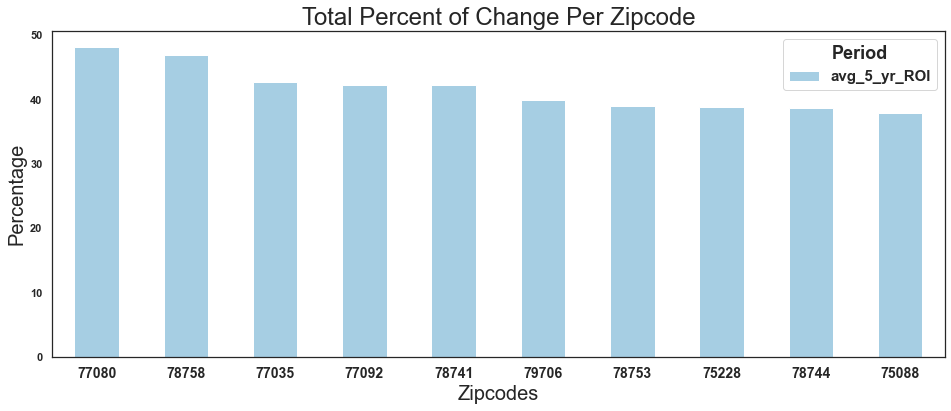

In [131]:
ax = TX_dff1.sort_values('avg_5_yr_ROI',ascending=False).head(10).plot(x="Zipcode", y='avg_5_yr_ROI', kind="bar", figsize=(16,6))
#df_Florida.sort_values('avg_5_yr_ROI',ascending=False).head(15).plot(x="Zipcode", y='avg_5_yr_ROI', kind="bar", color="C2", ax=ax)
#df_Florida.sort_values('avg_10_yr_ROI',ascending=False).head(10).plot(x="Zipcode", y='avg_10_yr_ROI', kind="bar", figsize=(16,6))
plt.title('Total Percent of Change Per Zipcode', size=24)
plt.legend(loc='best', title='Period',  title_fontsize=18, fontsize=15)
plt.xlabel('Zipcodes', size=20)
plt.xticks(rotation='horizontal', size=14)
plt.ylabel('Percentage', size=20)

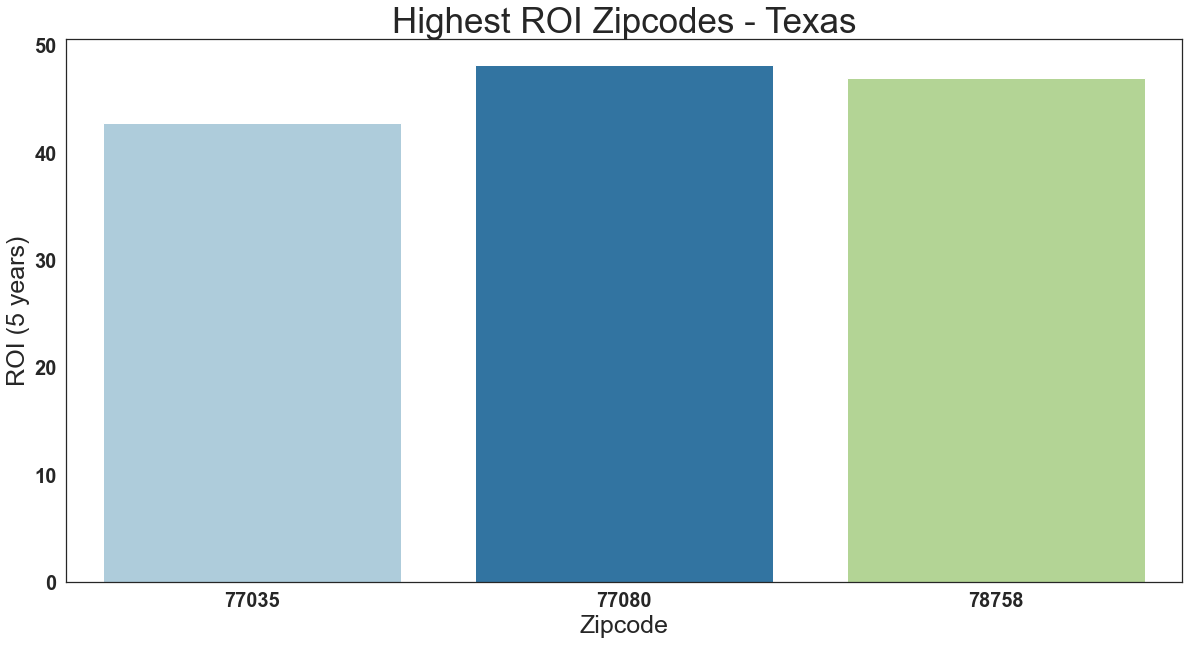

In [130]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.set(style = 'white')
palette = sns.set_palette(sns.color_palette("Paired"))
p = sns.barplot(x = "Zipcode", y = 'avg_5_yr_ROI', data = TX_df2[:3], color = palette)
p.set_xlabel("Zipcode", fontsize = 25)
p.set_ylabel("ROI (5 years average)", fontsize = 25)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
p.set_title("Highest ROI Zipcodes - Texas", fontsize = 35)

plt.show()

In [137]:
TX_map = folium.Map([32.82, -96.68], zoom_start = 6.3, width = '75%')
for lat, lon in zip(TX_df2['latitude'][:3], TX_df2['longitude'][:3]):
    folium.CircleMarker([lat, lon], radius = 10, color = 'darkred').add_to(TX_map)
TX_map

In [146]:
Top_3 = TX_df2.head(3)
Top_3

,latitude,longitude,Zipcode,City,State,avg_5_yr_ROI,irs_estimated_population
164,29.82,-95.52,77080,Houston,TX,48.192,36070
55,30.39,-97.71,78758,Austin,TX,46.932,37620
207,29.65,-95.48,77035,Houston,TX,42.748,29410


In [141]:
# Top 3 Zip Codes Time Series

df77080 = TX_df2[TX_df2['Zipcode']== 77080]
df77080.head()

,latitude,longitude,Zipcode,City,State,avg_5_yr_ROI,irs_estimated_population
164,29.82,-95.52,77080,Houston,TX,48.192,36070


In [142]:
df78758 = TX_df2[TX_df2['Zipcode']== 78758]

In [143]:
df77035 = TX_df2[TX_df2['Zipcode']== 77035]

In [89]:
#Utilizing the get_datetimes function given from the starter notebook
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[7:-5], format='%Y-%m')


In [90]:
get_datetimes(df78758)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [91]:
#font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!


IndentationError: unexpected indent (<ipython-input-91-0559b10b8e8f>, line 2)

In [ ]:
# melt_data function from the Starter notebook
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['Zipcode', 'RegionID', 'SizeRank', 'City', 'State', 
                                  'Metro', 'CountyName','latitude', 'longitude', 'irs_estimated_population','yr_avg', 'ROI_5']
                                 , var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('Date').aggregate({'value':'mean'}) 

In [ ]:
melted_78758 = melt_data(df78758)
melted_78758

In [ ]:
melted_75228 = melt_data(df75228)

In [ ]:
melted_75224 = melt_data(df75224)

In [ ]:
fig, ax = plt.subplots(figsize=(20,12))

ax.plot(melted_78758)
ax.plot(melted_75224)
ax.plot(melted_75228)

ax.tick_params(axis='both', which='major', labelsize=20)

ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Price in 100,000($)',fontsize=40)
ax.set_title('Top 3 Zip Codes History',fontsize=50);

In [ ]:
melted_TX = melt_data(TX_dff1)

In [ ]:
fig, ax = plt.subplots(figsize=(20,12))
ax.plot(melted_TX)

ax.set_xlabel('Year', fontsize=30)


ax.set_ylabel('Price in 100,000($)',fontsize=20)
ax.set_title('Texas (filtered) Price History',fontsize=30);

In [ ]:
train_set = melted_TX[:'2015-12']
val_set = melted_TX['2016-01':]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 9))
ax.plot(train_set, label = 'train')
ax.plot(val_set, label = 'test')


In [ ]:
split = TimeSeriesSplit()

# The ARIMA Models

# Fitting an AUTO-ARIMA Model on our Training Series Attempt

We find that finding the optimal p,d & q values and then fitting an ARIMA model can be a time consuming approach especially if we want to iterate this process over multiple zip codes. The benefit of using an AUTO-ARIMA model over an ARIMA model is that it helps eliminate the additional step of finding the optimal combination of p,d & q values and thereby it runs faster than an ARIMA model. The AUTO-ARIMA model performs this step for us and plugs in the p,d & q value combination that returns the lowest AIC score.

In [ ]:
# In order for this cell to run, you may need to install pmdarima if you haven't already.
!pip install pmdarima
import pmdarima as pm

auto_model = pm.auto_arima(train_set, start_p=0, start_q=0,
                     test='adf',
                     max_p=5, max_q=5,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)



print(auto_model.summary())

In [ ]:
#First Model
ar1 = ARIMA(train_set, order = (1, 1, 12)).fit()
ar1_pred = ar1.predict(typ='levels')

In [ ]:

ar1.summary()

In [ ]:
#Second Model

ar2 = ARIMA(train_set, order = (0, 1, 12)).fit()
ar2.predict(typ='levels')

In [ ]:
ar2.summary()

In [ ]:
#Third Model
ar3 = ARIMA(train_set, order = (0, 1, 12)).fit()
ar3.predict(typ='levels')

In [ ]:
ar3.summary()

In [ ]:
# Predictions and using mean_squared_error for our metric

yhat_ar1 = ar1.predict(typ='levels')
np.sqrt(mean_squared_error(train_set, yhat_ar1))

In [ ]:
fig, ax = plt.subplots()
ax.plot(ar1_pred)
ax.plot(train_set)

In [ ]:
plot_pacf(train_set.diff().dropna())

In [ ]:
train_set.plot()

In [ ]:
np.log(train_set).plot()

In [ ]:
np.sqrt(train_set).plot()

In [ ]:
decomposition = seasonal_decompose(np.log(train_set))
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [ ]:
plt.plot(seasonal)


In [ ]:
plt.plot(residual)


In [ ]:
train_log_dec = residual
train_log_dec = train_log_dec.dropna()

In [ ]:
# Utlizing the dickey-fuller test
dftest = adfuller(train_log_dec)

In [ ]:
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

In [ ]:
data_transform = np.sqrt(train_set)
diff = data_transform.diff().dropna()

In [ ]:
pd.DataFrame(np.hstack((data_transform[1:].values.reshape(-1, 1),diff.values.reshape(-1,1))))


In [ ]:
adfuller(diff)
